In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.read_csv('cifar_results.csv')

In [2]:
# Use exact parameter counts from CSV and calculate derived columns
if 'effective_model_size' not in df.columns:
    df['effective_model_size'] = df['num_parameters'] * df['logit_total_bits']
if 'accuracy' not in df.columns:
    df['accuracy'] = df['val_accuracy']

print(f"Loaded {len(df)} models/ensembles from CSV")
print(f"Parameter count range: {df['num_parameters'].min():.0f} - {df['num_parameters'].max():.0f}")

Loaded 304 models/ensembles from CSV
Parameter count range: 6621 - 594965


## Pareto Frontier: ensembles

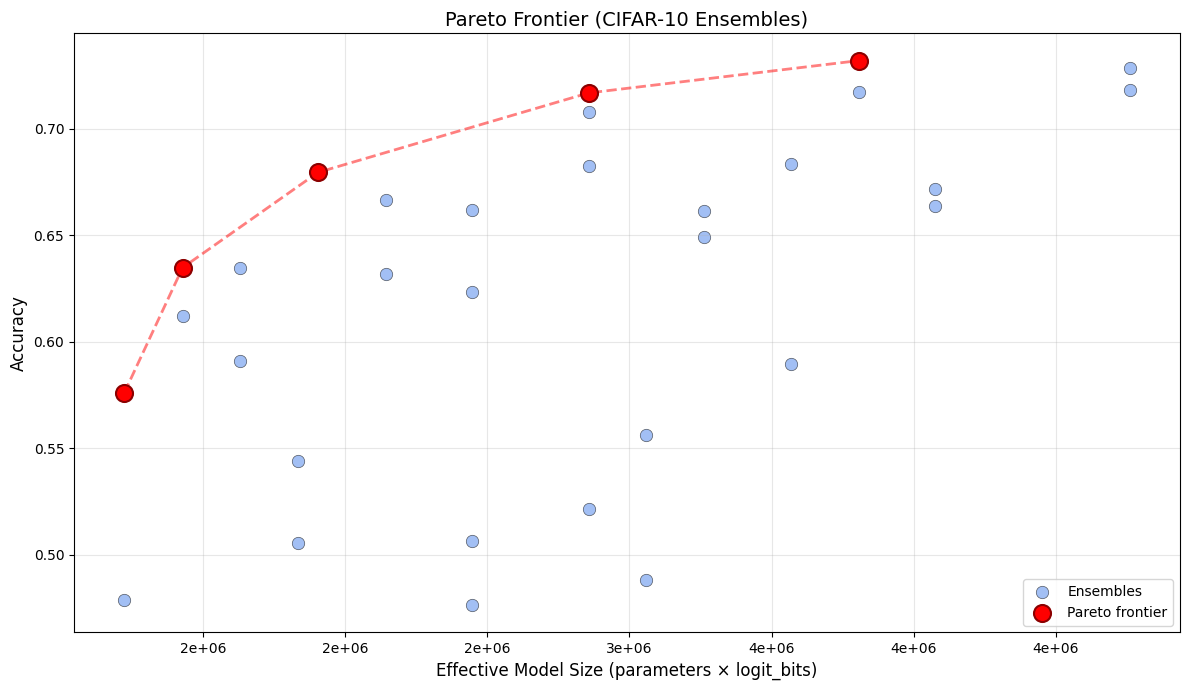

Total ensembles: 32
Pareto frontier points: 5

Pareto frontier details:
  Ensemble ensemble_12: size=1222836 bits, accuracy=0.5761, params=203806, logit_bits=6
  Ensemble ensemble_32: size=1427916 bits, accuracy=0.6348, params=237986, logit_bits=6
  Ensemble ensemble_44: size=1903888 bits, accuracy=0.6795, params=237986, logit_bits=8
  Ensemble ensemble_45: size=2855832 bits, accuracy=0.7168, params=356979, logit_bits=8
  Ensemble ensemble_46: size=3807776 bits, accuracy=0.7320, params=475972, logit_bits=8


In [3]:
# Filter for ensembles only (excluding 16-bit models)
df_ensembles = df[(df['ensemble_size'] > 1) & (df['logit_total_bits'] < 16)].copy()

# Extract data
x = df_ensembles['effective_model_size'].values
y = df_ensembles['accuracy'].values

# Find Pareto frontier
pareto_mask = np.ones(len(x), dtype=bool)
for i in range(len(x)):
    for j in range(len(x)):
        if i != j:
            if x[j] <= x[i] and y[j] >= y[i]:
                if x[j] < x[i] or y[j] > y[i]:
                    pareto_mask[i] = False
                    break

pareto_x = x[pareto_mask]
pareto_y = y[pareto_mask]

# Sort by x-axis
sort_idx = np.argsort(pareto_x)
pareto_x = pareto_x[sort_idx]
pareto_y = pareto_y[sort_idx]

plt.figure(figsize=(12, 7))

# Scatter plot for all ensembles in light blue
plt.scatter(x, y, c='#6495ED', alpha=0.6, s=80, 
            label='Ensembles', edgecolors='black', linewidth=0.5)

# Pareto frontier in red
plt.scatter(pareto_x, pareto_y, alpha=1, s=150, label='Pareto frontier', color='red', 
            edgecolors='darkred', linewidth=1.5, zorder=5)
plt.plot(pareto_x, pareto_y, 'r--', alpha=0.5, linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0e}'))

plt.xlabel('Effective Model Size (parameters × logit_bits)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Pareto Frontier (CIFAR-10 Ensembles)', fontsize=14)
plt.legend(fontsize=10, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total ensembles: {len(df_ensembles)}")
print(f"Pareto frontier points: {len(pareto_x)}")
print("\nPareto frontier details:")
for i in range(len(pareto_x)):
    idx = np.where((x == pareto_x[i]) & (y == pareto_y[i]))[0][0]
    row = df_ensembles.iloc[idx]
    print(f"  Ensemble {row['ensemble_dir']}: size={pareto_x[i]:.0f} bits, accuracy={pareto_y[i]:.4f}, params={row['num_parameters']}, logit_bits={row['logit_total_bits']}")

## Pareto Frontier: All Models

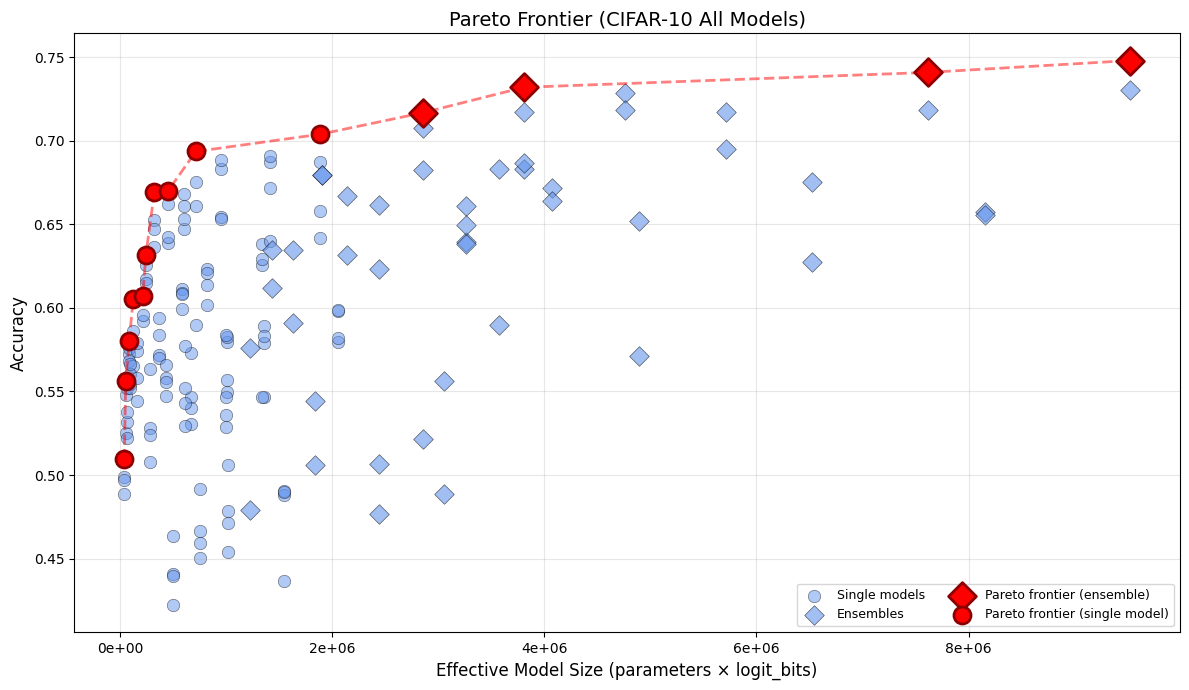

Total items (ensembles + models with logit_bits >= 6): 176
  Ensembles: 48
  Single models: 128
Pareto frontier points: 14
  From ensembles: 4
  From single models: 10


In [4]:
# Filter data: Ensembles (ensemble_size > 1) or models with logit_bits >= 6, excluding logit_bits=16
df_filtered = df[
    ((df['ensemble_size'] > 1) | 
     ((df['ensemble_size'] == 1) & (df['logit_total_bits'] >= 6))) 
].copy()

# Separate ensembles and single models
ensemble_mask_filtered = df_filtered['ensemble_size'] > 1
single_model_mask_filtered = df_filtered['ensemble_size'] == 1

# Extract data for ensembles and single models
x_ensemble = df_filtered.loc[ensemble_mask_filtered, 'effective_model_size'].values
y_ensemble = df_filtered.loc[ensemble_mask_filtered, 'accuracy'].values
logit_bits_ensemble = df_filtered.loc[ensemble_mask_filtered, 'logit_total_bits'].values

x_single = df_filtered.loc[single_model_mask_filtered, 'effective_model_size'].values
y_single = df_filtered.loc[single_model_mask_filtered, 'accuracy'].values
logit_bits_single = df_filtered.loc[single_model_mask_filtered, 'logit_total_bits'].values

# Combined data for Pareto frontier calculation
x_combined = df_filtered['effective_model_size'].values
y_combined = df_filtered['accuracy'].values

# Find Pareto frontier
pareto_mask_combined = np.ones(len(x_combined), dtype=bool)
for i in range(len(x_combined)):
    for j in range(len(x_combined)):
        if i != j:
            if x_combined[j] <= x_combined[i] and y_combined[j] >= y_combined[i]:
                if x_combined[j] < x_combined[i] or y_combined[j] > y_combined[i]:
                    pareto_mask_combined[i] = False
                    break

pareto_x_combined = x_combined[pareto_mask_combined]
pareto_y_combined = y_combined[pareto_mask_combined]
pareto_types = df_filtered['ensemble_size'].values[pareto_mask_combined] > 1  # True = ensemble, False = single model

# Sort by x-axis
sort_idx_combined = np.argsort(pareto_x_combined)
pareto_x_combined = pareto_x_combined[sort_idx_combined]
pareto_y_combined = pareto_y_combined[sort_idx_combined]
pareto_types = pareto_types[sort_idx_combined]

# Create the combined plot
plt.figure(figsize=(12, 7))

# Plot single models (circles) in light blue
plt.scatter(x_single, y_single, c='#6495ED', alpha=0.5, s=80, marker='o', 
           label='Single models', edgecolors='black', linewidth=0.5)

# Plot ensembles (diamonds) in light blue
plt.scatter(x_ensemble, y_ensemble, c='#6495ED', alpha=0.6, s=100, marker='D', 
           label='Ensembles', edgecolors='black', linewidth=0.5)

# Pareto frontier: diamonds for ensembles, circles for single models
ensemble_frontier = pareto_types
single_frontier = ~pareto_types
if np.any(ensemble_frontier):
    plt.scatter(pareto_x_combined[ensemble_frontier], pareto_y_combined[ensemble_frontier], 
               alpha=1, s=200, marker='D', color='red', edgecolors='darkred', linewidth=2, zorder=5, label='Pareto frontier (ensemble)')
if np.any(single_frontier):
    plt.scatter(pareto_x_combined[single_frontier], pareto_y_combined[single_frontier], 
               alpha=1, s=150, marker='o', color='red', edgecolors='darkred', linewidth=2, zorder=5, label='Pareto frontier (single model)')

plt.plot(pareto_x_combined, pareto_y_combined, 'r--', alpha=0.5, linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0e}'))

plt.xlabel('Effective Model Size (parameters × logit_bits)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Pareto Frontier (CIFAR-10 All Models)', fontsize=14)
plt.legend(fontsize=9, loc='lower right', ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total items (ensembles + models with logit_bits >= 6): {len(df_filtered)}")
print(f"  Ensembles: {len(df_filtered[ensemble_mask_filtered])}")
print(f"  Single models: {len(df_filtered[single_model_mask_filtered])}")
print(f"Pareto frontier points: {np.sum(pareto_mask_combined)}")
print(f"  From ensembles: {np.sum(ensemble_frontier)}")
print(f"  From single models: {np.sum(single_frontier)}")